In [153]:
# importing modules
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# import self-written functions
from helper import get_manhattan_plot

# GWAS
Genome Wide Association Study (GWAS) is an approach used to link genotypic variants to phenotypic traits of interest. It is useful especially to link complex traits. [1]  

# PLINK
PLINK is an opensource toolset developed by Purcell et. al. to analyze GWAS data [2]. It is one of the most common tools used for this purpose and it does so in a computationally efficient manner. 

*I used conda to download plink. The environment file is available here :* [3]

# UnEssay Goal
The goal of this UnEssay assignment is to demonstrate the use of plink to better understand the role of analysing GWAS data towards successfully linking a genetic variant to a phenotypic trait.

# Dataset 
The dataset used for this tutorial is a simulated sample of 89 individuals. The individuals are from 2 different subpopulations. 83534 genetic variants among the entire genome of these individuals have been used on this study with one of the variants directly linked to a simulated disease phenotype. The phenotypic trait was generated as a function of three components: 

1. A variant on chromosome 2, rs2222162
2. subpopulation identity  
3. a random component. 

The dataset has 4 files, 2 among which will be used for the purpose of this study,

1. hapmap1.ped file 
2. hapmap1.map file

Each of these files, which are essential for the association study and will be used by plink to analyse the data to come to biologically relevant conclusions, is described in the following section.

*The dataset is available here:* [4]

In [5]:
# downloading the data as a zip file
!url='http://zzz.bwh.harvard.edu/plink/hapmap1.zip'
!curl --output data/hapmap1.zip $url

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2846k  100 2846k    0     0  1153k      0  0:00:02  0:00:02 --:--:-- 1153k


In [7]:
# unzipping the zip file
!tar -xvf data/hapmap1.zip

x hapmap1.ped
x hapmap1.map
x pop.phe
x qt.phe


# Explore dataset
Here, we will explore the two files mentioned above and describe its contents.

##  ped file
The ped file contains the genotype information of each individual who participated in the study. It has six mandatory columns that encode specific information of an individual followed by a variable number of columns that describe the genetic variants of that particualr individual. 
The first 6 mandatory columns contain the following information:

1. Family ID 
2. Individual ID 
3. Paternal ID 
4. Maternal ID 
5. Sex (1=male; 2=female; other=unknown) 
6. Phenotype 

In our case, since we are looking at 83534 genetic variants, the number of columns should be 6 + 83534\*2 (diploid individual) or 167074. Since we are looking at 89 individuals, the number of rows should be 89.  We verify both rows and columns in the following code cell.

In [39]:
with open('data/hapmap1.ped','r') as file:
    genetic_info = []
    for lines in file:
        data = lines.strip('\n').split(' ')
        genetic_info.append(data)

In [43]:
print(f'The number of individuals studied here is {len(genetic_info)}.')

The number of individuals studied here is 89.


In [45]:
print(f'The number of columns corresponding to each individual is {len(genetic_info[0])}.')

The number of columns corresponding to each individual is 167074.


## map file
Each line in the map file describes a single genetic variant and it contains 4 columns which has the following information about the variant:

1. chromosome number where the variant is found
2. snp identifier, an unique id for the variant
3. Genetic distance in morgans
4. Base-pair position of the variant

We take a look below at the first 5 lines of our map file, hapmap1.map 

In [46]:
!cat data/hapmap1.map | head -n 5

1 rs6681049 0 1
1 rs4074137 0 2
1 rs7540009 0 3
1 rs1891905 0 4
1 rs9729550 0 5
cat: stdout: Broken pipe


# Simple Association between genotype and phenotype
Next we perform an association analysis of our data to determine the potential causal variant responsible for the disease trait.

In [82]:
!plink --file data/hapmap1 --assoc --silent --out results/basic

We take a look at the association file prepared by plink below. It is named basic.assoc and it has the following columns:

1. Chromosome
2. SNP identifier
3. Base Position
4. Code for allele 1 (the minor, rare allele based on the entire sample frequencies)
5. The frequency of this variant in cases
6. The frequency of this variant in controls
7. Code for the other allele
8. The chi-squared statistic for this test (1 df)
9. The asymptotic significance value for this test
10. The odds ratio for this test 

In [87]:
assoc_df = pd.read_csv('results/basic.assoc',delimiter=r'\s+',engine='python')
assoc_df.head()

,CHR,SNP,BP,A1,F_A,F_U,A2,CHISQ,P,OR
0,1,rs6681049,1,1,0.15910,0.26670,2,3.067000,0.07991,0.5203
1,1,rs4074137,2,1,0.07955,0.07778,2,0.001919,0.96510,1.0250
2,1,rs7540009,3,0,0.00000,0.00000,2,NaN,NaN,NaN
3,1,rs1891905,4,1,0.40910,0.40000,2,0.015270,0.90170,1.0380
4,1,rs9729550,5,1,0.17050,0.08889,2,2.631000,0.10480,2.1060


We can check to see if our known variant rs2222162 is present in the analysis file as a significant SNP based on P-value by sorting the association file by the P-value column.

In [88]:
assoc_df.sort_values(by='P').head()

,CHR,SNP,BP,A1,F_A,F_U,A2,CHISQ,P,OR
64273,13,rs9585021,64274,1,0.6250,0.28410,2,20.62,0.000006,4.2000
10601,2,rs2222162,10602,1,0.2841,0.62220,2,20.51,0.000006,0.2409
46334,9,rs10810856,46335,1,0.2955,0.04444,2,20.01,0.000008,9.0160
13219,2,rs4675607,13220,1,0.1628,0.47780,2,19.93,0.000008,0.2125
13217,2,rs4673349,13218,1,0.1818,0.50000,2,19.83,0.000008,0.2222


We can see that the simulated causal variant, rs2222162, is the second most significant SNP in our analysis. The SNP rs9585021 which is predicted to be the most significant SNP by plink can possibly be in linkage disquilibrium with the causal SNP or it may have just occurred randomly as a significant SNP. 

## Manhattan Plot of the association
We can visualize our association results using a Manhattan plot. 

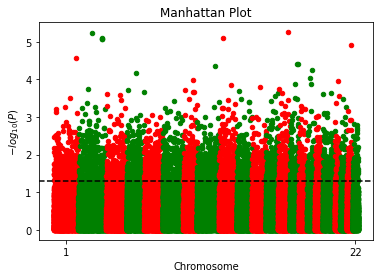

In [156]:
get_manhattan_plot(assoc_df,'P')

We can see multiple (too many) genetic variants above the p-value threshold of 0.05. We should however take care of the multiple testing criterion since we are performing so many tests. 

# Adjusted association between genotype and phenotype
To take care of error due to multiple testing, we can even perform an adjusted association study. 

In [147]:
!plink --file data/hapmap1 --assoc --adjust --silent --out results/adjust

We take a look at the adjusted association file created by plink. In this file, there are 10 columns for every genetic variant, described below:


1. Chromosome number where the variant lies, CHR
2. SNP identifier of the variant, SNP
3. Unadjusted, asymptotic significance value, UNADJ
4. Genomic control adjusted significance value, GC. This is based on a simple estimation of the inflation factor based on median chi-square statistic. These values do not control for multiple testing therefore.
5. Bonferroni adjusted significance value, BONF
6. Holm step-down adjusted significance value, HOLM
7. Sidak single-step adjusted significance value, SIDAK_SS
8. Sidak step-down adjusted significance value, SIDAK_SD
9. Benjamini & Hochberg (1995) step-up FDR control, FDR_BH
10. Benjamini & Yekutieli (2001) step-up FDR control, FDR_BY 

In [149]:
adj_assoc_df = pd.read_csv('results/adjust.assoc.adjusted',delimiter=r'\s+',engine='python')
adj_assoc_df.head()

,CHR,SNP,UNADJ,GC,BONF,HOLM,SIDAK_SS,SIDAK_SD,FDR_BH,FDR_BY
0,13,rs9585021,0.000006,0.000050,0.3839,0.3839,0.3188,0.3188,0.09719,1
1,2,rs2222162,0.000006,0.000052,0.4068,0.4067,0.3342,0.3342,0.09719,1
2,9,rs10810856,0.000008,0.000065,0.5308,0.5308,0.4118,0.4118,0.09719,1
3,2,rs4675607,0.000008,0.000067,0.5533,0.5533,0.4249,0.4249,0.09719,1
4,2,rs1375352,0.000008,0.000070,0.5832,0.5831,0.4419,0.4419,0.09719,1


The manhattan plot is shown below using the Bonferroni adjusted significance value instead of the unadjusted P value

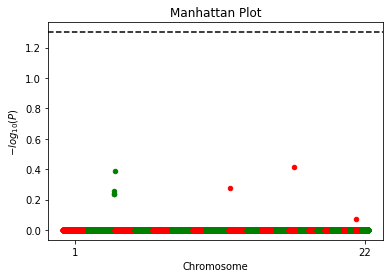

In [157]:
get_manhattan_plot(adj_assoc_df,'BONF')

As we can see above, after our adjustments, none of them are even close to the significant threshold. So far, we have ignored the effect of having two different subpopulations and must take these into account. Since we already know that we have two distinct subpopulations in our simulated sample, it is easy for us to cluster them into two groups by specifying the number of clusters to plink. However, in real scenario, we do not know beforehand how many clusters to select.  

# Stratifying the data by subpopulation 
Here, we divide our dataset into 2 clusters based on their genetic variants.

In [159]:
!plink --file data/hapmap1 --cluster --silent --K 2 --out results/popclust

# Adjusted value after stratification
Next we will use the stratified dataset to perform our adjusted analysis using plink and visualize it using the manhattan plot.

In [162]:
!plink --file data/hapmap1 --mh --silent --within popclust.cluster2 --adjust --out results/final

In [164]:
clust_adj_assoc_df = pd.read_csv('results/final.cmh.adjusted',delimiter=r'\s+',engine='python')
clust_adj_assoc_df.head()

,CHR,SNP,UNADJ,GC,BONF,HOLM,SIDAK_SS,SIDAK_SD,FDR_BH,FDR_BY
0,2,rs2222162,3.534000e-07,7.705000e-07,0.02429,0.02429,0.0240,0.0240,0.02429,0.2846
1,13,rs9585021,3.678000e-06,7.033000e-06,0.25280,0.25270,0.2233,0.2233,0.12640,1.0000
2,2,rs4675607,9.038000e-06,1.644000e-05,0.62110,0.62110,0.4627,0.4627,0.19060,1.0000
3,2,rs1375352,1.386000e-05,2.463000e-05,0.95280,0.95270,0.6143,0.6143,0.19060,1.0000
4,2,rs4673349,1.386000e-05,2.463000e-05,0.95280,0.95270,0.6143,0.6143,0.19060,1.0000


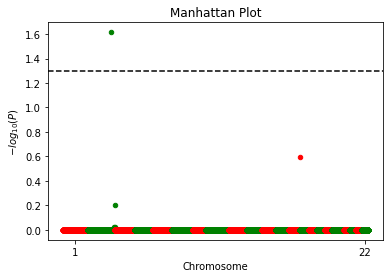

In [165]:
get_manhattan_plot(clust_adj_assoc_df,'BONF')

Now we can clearly see that only one SNP is significant after adjusting the p-value using Bonferroni correction to take care of multiple testing. We see that the significant variant is indeed our simulated causal variant rs2222162 present in chromosome 2.

**Please note that this is a simplified example adopted from PLINK tutorial. The actual scenario will be much more complicated.**

# Conclusion

In conclusion, we can say that GWAS can be an extremely useful approach to help us answer the most important question in human genetics, which genetic variants are linked to clinical traits. PLINK can be a helpful tool to analyse GWAS data as illustrated by this example.

*All the codes related to this assignment are available in the github repositiory* [3]. 

# References

1. https://www.cell.com/ajhg/fulltext/S0002-9297(17)30240-9
2. https://www.cell.com/ajhg/fulltext/S0002-9297(07)61352-4
3. git repo
4. http://zzz.bwh.harvard.edu/plink/hapmap1.zip

# To-Do

1. Rerun
2. Finish reference tagging
3. Finish github page